<a href="https://colab.research.google.com/github/du-hr/MNIST-CNN/blob/good_copy/MiniProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProject 3: Multi-label Classification of Image Data


> MiniProject 3 of COMP 551 (Fall 2020) at McGill University


> Authors (G17): Haoran Du (260776911), Robin Cho (260806783), Teresa Lee (260715070)

In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import h5py
import torch
from google.colab import drive
# ignore the follwoing line if running locally
drive.mount('/content/drive')
# make path = './' if running locally
path = '/content/drive/My Drive/'

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

Mounted at /content/drive


# **1. Dataset**

## **1.1 Import Data**

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>
(56000, 64, 64, 1)


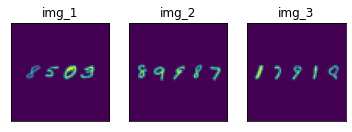

(56000, 5)
[[ 8  5  0  3 10]
 [ 8  9  9  8  7]
 [ 1  7  9  1  8]
 ...
 [ 4  4 10 10 10]
 [ 7  9  8 10 10]
 [ 6 10 10 10 10]]


In [2]:
# load the datasets
with h5py.File(path+'MNIST_synthetic.h5', 'r') as hdfid:
     print(hdfid.keys())
     test_images = hdfid['test_dataset'][()]
     train_images = hdfid['train_dataset'][()]
     train_labels = hdfid['train_labels'][()]

# display train_images properties
print(train_images.shape)
# print(train_iamges[10][30])

# plot first 3 images in train_images
images=[]
titles=[]
images.append(np.array(train_images[0], dtype='float').reshape(64,64))
titles.append("img_1")
images.append(np.array(train_images[1], dtype='float').reshape(64,64))
titles.append("img_2")
images.append(np.array(train_images[2], dtype='float').reshape(64,64))
titles.append("img_3")

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

# display train_labels properties
print(train_labels.shape)
print(train_labels)

## **1.2 Class Distribution**

In [ ]:
unique_y1, counts_y1 = np.unique(train_labels[:, 0], return_counts=True)
plt.bar(unique_y1, counts_y1/sum(counts_y1))
plt.xticks(unique_y1, unique_y1)
plt.title(f"Class Distribution of the first column")
plt.show()

In [ ]:
unique_y2, counts_y2 = np.unique(train_labels[:, 1], return_counts=True)
plt.bar(unique_y2, counts_y2/sum(counts_y2))
plt.xticks(unique_y2, unique_y2)
plt.title(f"Class Distribution of the second column")
plt.show()

In [ ]:
unique_y3, counts_y3 = np.unique(train_labels[:, 2], return_counts=True)
plt.bar(unique_y3, counts_y3/sum(counts_y3))
plt.xticks(unique_y3, unique_y3)
plt.title(f"Class Distribution of the third column")
plt.show()

In [ ]:
unique_y4, counts_y4 = np.unique(train_labels[:, 3], return_counts=True)
plt.bar(unique_y4, counts_y4/sum(counts_y4))
plt.xticks(unique_y4, unique_y4)
plt.title(f"Class Distribution of the fourth column")
plt.show()

In [ ]:
unique_y5, counts_y5 = np.unique(train_labels[:, 4], return_counts=True)
plt.bar(unique_y5, counts_y5/sum(counts_y5))
plt.xticks(unique_y5, unique_y5)
plt.title(f"Class Distribution of the fifth column")
plt.show()

# **2. First Approach**
Train a mult-label classification model

# **3. Second Approach**
Partition the images and train a single label classification model

## **3.1 Data Preprocessing**
- partition images
- create data loader

### **3.1.1 Data and Exploring Number of Digits**

In [3]:
# normalize to range 0-1 with typecast to float
def data_scaled(x):
  scaled_x = x.astype('float32') / 255.0
  return scaled_x

scaled_train_images = data_scaled(train_images)
X_train = torch.from_numpy(scaled_train_images)
Y_train = torch.from_numpy(train_labels.astype('int32'))

Before deciding a way to partition the data, we also explore several functions in openCV.

In [ ]:
threshold = 1
width = 12
height = 12

In [ ]:
def findDigits(img):
  #Note that a normalized image does not work
  ret,thresh = cv2.threshold(img,threshold,255,0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  #print(len(contours))
  def getKey(item):
    return item[0]

  digitsLoc = []
  minArea = 15
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w == 1 and h > 4:
      listTemp = [x, y, w, h]
      digitsLoc.append(listTemp)
    
    elif w * h > minArea:
      listTemp = [x, y, w, h]
      digitsLoc.append(listTemp)
  
  return sorted(digitsLoc, key = lambda x: x[0])

In [ ]:
images_scaled=[]
images_scaled.append(np.array(train_images[4476], dtype='float').reshape(64,64))
sample = plt.imshow(images_scaled[0])
plt.show()

#x = findDigits(train_images[3282])
passed = 0
total = 0

for i in range(0, 56000):
  x = len(findDigits(train_images[i]))
  n = 0
  for c in train_labels[i]:
    if c != 10:
      n = n + 1
  
  if n == x:
    passed = passed + 1
  else:
    print("Case#: ",i, "Detected: " ,x, " Expected: ", n)
  total = total + 1

print(passed/total)

### **3.1.2 Calculating the bounds of the images**


*   lowerBound(x): return the minimum lower bound of the images
*   upperBound(x): return the maximum upper bound of the image
*   leftBound(x): return the minimum left bound of the images
*   rightBound(x): return the maximum right bound of the images
These calculations are used for partitioning the images



In [4]:
def lowerBound(x):
  N = x.shape[1]
  D = x.shape[0]
  lowerBounds = [0]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, j], bound)):
        lowerBounds[i] = j + 1
      else:
        break
  return min(lowerBounds)
  
def upperBound(x):
  N = x.shape[1]
  D = x.shape[0]
  upperBounds = [64]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, 63-j], bound)):
        upperBounds[i] = 63-j
      else:
        break
  return max(upperBounds)

In [ ]:
def leftBound(x):
  N = x.shape[2]
  D = x.shape[0]
  leftBounds = [0]*D
  bound = x[0, :, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, :, j], bound)):
        leftBounds[i] = j + 1
      else:
        break
  return min(leftBounds)
  
def rightBound(x):
  N = x.shape[2]
  D = x.shape[0]
  rightBounds = [64]*D
  bound = x[0, :, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, :, 63 - j], bound)):
        rightBounds[i] = 63 - j
      else:
        break
  return max(rightBounds)

In [ ]:
u = upperBound(X_train)
l = lowerBound(X_train)
l2 = leftBound(X_train)
r = rightBound(X_train)

print("Upper bound: ", u,", Lower bound:", l, ", Left bound: ", l2,", Right bound:", r)

### **3.1.3 Partitioning the images**
*   leftBound_digit(x): calculate the first column that has pixels more than certain threshold
*   rightBound_digit(x): calculate the first column that has pixels less than certain threshold
*   partition_image(x): use the above two functions to partition an image
*   partition_image_number_of_digits_accuracy(x): use the partition_image(x) to return the number of digits in each image
*   accuracy_check(x): check whether the digits correspond to the labels
*   incorrect_list(x): sort the index of incorrect digits (for removing them)
*   dataset_images_partition(x): apply the parition_image(x) on the entire dataset

In [5]:
def leftBound_digit(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.full(x[:, 0].shape, 0.2)
  #0.2 is the threshold of the partitioning, this is selected by a later accuracy check
  for i in list(range(initial_column, N)):
    if torch.all(torch.le(x[:, i], bound)):
      leftBound = i + 1
    else:
      break
  return leftBound

def rightBound_digit(x, initial_column):
  N = x.shape[1] #column
  rightBound = 0
  bound = torch.full(x[:, 0].shape, 0.2)
  for i in list(range(initial_column, N)):
    if torch.all(torch.le(x[:, i], bound)) == False:
      rightBound = i + 1
    else:
      break
  return rightBound

In [6]:
def partition_image(x):
  x = x.reshape(64, 64)
  l = leftBound_digit(x, 0)
  r = rightBound_digit(x, l)
  x_1 = torch.zeros((12, 12))
  x_1[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]

  l = leftBound_digit(x, r)
  if l == 64: #i.e. one digit
    x_2 = torch.zeros((12, 12))
    x_3 = torch.zeros((12, 12))
    x_4 = torch.zeros((12, 12))
    x_5 = torch.zeros((12, 12))
  else:
    r = rightBound_digit(x, l)
    x_2 = torch.zeros((12, 12))
    x_2[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]

    l = leftBound_digit(x, r)

    if l == 64: #i.e. two digits
      x_3 = torch.zeros((12, 12))
      x_4 = torch.zeros((12, 12))
      x_5 = torch.zeros((12, 12))
    else:
      r = rightBound_digit(x, l)
      x_3 = torch.zeros((12, 12))
      x_3[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
      l = leftBound_digit(x, r)

      if l == 64: #i.e. three digits
        x_4 = torch.zeros((12, 12))
        x_5 = torch.zeros((12, 12))
      else:
        r = rightBound_digit(x, l)
        x_4 = torch.zeros((12, 12))
        x_4[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
        l = leftBound_digit(x, r)

        if l == 64:  #i.e. four digits
          x_5 = torch.zeros((12, 12))
        else: #i.e. five digits
          r = rightBound_digit(x, l)
          x_5 = torch.zeros((12, 12))
          x_5[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
    
  x_0 = torch.stack((x_1, x_2, x_3, x_4, x_5))

  return x_0

In [ ]:
x_try = X_train[0].reshape(64, 64)
plt.imshow(x_try)

In [ ]:
x_try_part = partition_image(x_try)
for i in range(5):
    plt.subplot(1,5,i+1),plt.imshow(x_try_part[i, :, :])
    plt.xticks([]),plt.yticks([])

In [7]:
#this code returns the number of digits
def partition_image_number_of_digits_accuracy(x):
  x = x.reshape(64, 64)
  l = leftBound_digit(x, 0)
  r = rightBound_digit(x, l)
  l = leftBound_digit(x, r)
  if l == 64: #i.e. one digit
    n = 1
  else:
    r = rightBound_digit(x, l)
    l = leftBound_digit(x, r)

    if l == 64: #i.e. two digits
      n = 2
    else:
      r = rightBound_digit(x, l)
      l = leftBound_digit(x, r)

      if l == 64: #i.e. three digits
        n = 3
      else:
        r = rightBound_digit(x, l)
        l = leftBound_digit(x, r)

        if l == 64:  #i.e. four digits
          n = 4
        else: #i.e. five digits
          r = rightBound_digit(x, l)
          n = 5
  return n

In [ ]:
def accuracy_check(x, y):
  D = x.shape[0]
  Y_true = torch.zeros(D)
  for i in list(range(0, D)):
    n = 0
    for c in y[i]:
      if c != 10:
        n = n + 1
    Y_true[i] = n

  correct = 0
  incorrect = 0
  for i in list(range(0, D)):
    if Y_true[i] == partition_image_number_of_digits_accuracy(x[i]):
      correct = correct + 1
    else:
      incorrect = incorrect +1
  return correct/(incorrect+correct)

In [ ]:
accuracy_check(X_train, train_labels)

In [ ]:
#The accuracy is 0.994 when set threshold = 0
#The accuracy is 0.996 when set threshold = 0.25
#The accuracy is 0.986 when set threshold = 0.361

In [8]:
def incorrect_list(x, y):
  D = x.shape[0]
  Y_true = torch.zeros(D)
  for i in list(range(0, D)):
    n = 0
    for c in y[i]:
      if c != 10:
        n = n + 1
    Y_true[i] = n

  correct = 0
  incorrect = []
  for i in list(range(0, D)):
    if Y_true[i] == partition_image_number_of_digits_accuracy(x[i]):
      correct = correct + 1
    else:
      incorrect.append(i)
  return incorrect

In [9]:
#We decided the remove the images that failed to provide suitable partitioning
#Since the labels in the testing images are not provided, we decided to do some data engineering if the function is not suitable
incorrect_digits = incorrect_list(X_train, train_labels)

In [10]:
correct_digits = list(range(0, X_train.shape[0]))
correct_digits = list(np.delete(np.array(correct_digits), (incorrect_digits), axis=0))

In [ ]:
accuracy_check(X_train[correct_digits, :], train_labels[correct_digits, :])

In [11]:
def dataset_images_partition(x):
  d1 = x.shape[0]
  d2 = 5
  d3 = 12
  d4 = 12
  X_new = torch.zeros((d1, d2, d3, d4))
  for i in list(range(0, d1)):
    X_new[i] = partition_image(x[i])
  return X_new

In [12]:
X_train_part = dataset_images_partition(X_train[correct_digits, :])
Y_train_part = Y_train[correct_digits, :]

### **3.1.4 Creating dataloaders**

*   x_multiLabel_to_singleLabel(x): convert the n samples multilabels data into a n*(number of labels) samples single label data
*   y_multiLabel_to_singleLabel(y): same as above, but this is for the labels
*   The data loaders created in this section are used for training models in the next subsection.
*   The two data loaders are separated by a random split. One of them is used as the validation set.





In [13]:
def x_multiLabel_to_singleLabel(x):
  n = x.shape[0]
  n2 = x.shape[2]
  n3 = x.shape[3]
  new_x = torch.zeros((n*5, 1, n2, n3))
  for i in list(range(0, n)):
    for j in list(range(0, 5)):
      new_x[i*5+j] = x[i, j]
  return new_x

In [14]:
X_train_part2 = x_multiLabel_to_singleLabel(X_train_part)

In [15]:
def y_multiLabel_to_singleLabel(y):
  n = y.shape[0]
  new_y = torch.zeros((n*5))
  for i in list(range(0, n)):
    for j in list(range(0, 5)):
      new_y[i*5+j] = y[i, j]
  return new_y

In [16]:
Y_train_part2 = y_multiLabel_to_singleLabel(Y_train_part)

In [18]:
from random import seed
from random import randint
seed(1)
# generate 6000 random integers for validation set
val_index = np.random.choice(55853*5, 6000*5, replace=False)
print(len(val_index))
train_index = np.setxor1d(np.arange(55853*5),val_index)
print(len(train_index))

30000
249265


In [19]:
from torch.utils.data import Dataset, DataLoader
class train_images_data(Dataset):
    def __init__(self):
      self.x = X_train_part2[train_index, :]
      self.y = Y_train_part2[train_index]
      self.n_samples = X_train_part2[train_index, :].shape[0]
    
    def __getitem__(self, index):
      return self.x[index], self.y[index]
    
    def __len__(self):
      return self.n_samples


train_data = train_images_data()
train_dataloader = DataLoader(dataset=train_data, batch_size = 16, shuffle = True)

In [20]:
class val_images_data(Dataset):
    def __init__(self):
      self.x = X_train_part2[val_index, :]
      self.y = Y_train_part2[val_index]
      self.n_samples = X_train_part2[val_index, :].shape[0]
    
    def __getitem__(self, index):
      return self.x[index], self.y[index]
    
    def __len__(self):
      return self.n_samples


val_data = val_images_data()
val_dataloader = DataLoader(dataset=val_data, batch_size = 16, shuffle = True)

In [36]:
import torchvision
images, labels = next(iter(train_dataloader))
images.shape

torch.Size([16, 1, 12, 12])

## **3.2 Model Training**

In [4]:
class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1, 64, 3, 1, 1),
                                     torch.nn.ReLU(),
                                     torch.nn.Conv2d(64, 128, 3, 1, 1),
                                     torch.nn.MaxPool2d(2, 2))
    self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128, 1024),
                                     torch.nn.ReLU(),
                                     torch.nn.Dropout(p = 0.5),
                                     torch.nn.Linear(1024, 10))
  
  def forward(self, x):
    x = self.conv1(x)
    x = x.view(-1, 14*14*128)
    x = self.dense(x)
    return x

In [ ]:
import torch
device = torch.device('cuda')
model2 = Model()
model2.to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.5)

In [ ]:
for epoch in range(20):
  total_train_lost = 0.0
  total_val_lost = 0.0
  train_correct = 0
  val_correct = 0
  for data in train_dataloader:
    inputs, labels = data
    inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
    optimizer.zero_grad()
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    optimizer.step()

    _, pred = torch.max(outputs.data, 1)
    total_train_lost = total_train_lost + loss.data
    train_correct = train_correct + torch.sum(id==labels.data)
  
  model2.eval()
  for data in val_dataloader:
    inputs, labels = data
    inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
    optimizer.zero_grad()
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    optimizer.step()

    _, pred = torch.max(outputs.data, 1)
    total_val_lost = total_val_lost + loss.data
    val_correct = val_correct + torch.sum(id==labels.data)
  train_accuracy = train_correct/len(train_data)
  val_accuracy = val_correct/len(val_data)
  print('\nEpoch: {}/{}, Train Loss: {:.8f}, Train Accuracy: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, train_accuracy, total_val_loss, val_accuracy))


## **4. Application to Testing Images**